In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [6]:
import sys

In [7]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [8]:
sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings
from loaders import load_sabes
from segmentation import reach_segment_sabes
from subspaces import SubspaceIdentification, IteratedStableEstimator, estimate_autocorrelation

In [9]:
# Save the following:

# (1) Reduced histogram of single unit statistics
# (2) Scatter of FCCA vs PCA loadings 
# (3) Examples PSTH, Entropy/magnitude tests

In [10]:
dpath = '/mnt/Secondary/data/sabes/'
#dpath = '/mnt/sdb1/nc_data/sabes'

In [11]:
# with open('/mnt/sdb1/nc_data/sabes_decoding_df.dat', 'rb') as f:
#     sabes_df = pickle.load(f)

with open('/home/akumar/nse/neural_control/data/sabes_decoding_df.dat', 'rb') as f:
    sabes_df = pickle.load(f)

In [11]:
sabes_l = sabes_df.to_dict('records')

In [12]:
# with open('/home/akumar/nse/neural_control/data/sabes_decoding_list.dat', 'wb') as f:
#     f.write(pickle.dumps(sabes_l))

In [35]:
DIM = 6

In [12]:
# Try the raw leverage scores instead
loadings_l = []
data_files = np.unique(sabes_df['data_file'].values)
for i, data_file in tqdm(enumerate(data_files)):
        loadings = []
        for dimreduc_method in ['DCA', 'KCA', 'LQGCA', 'PCA']:
            loadings_fold = []
            for fold_idx in range(5):            
                df_ = apply_df_filters(sabes_df, data_file=data_file, fold_idx=fold_idx, dim=6, dimreduc_method=dimreduc_method)
                if dimreduc_method == 'LQGCA':
                    df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 5})
                V = df_.iloc[0]['coef']
                if dimreduc_method == 'PCA':
                    V = V[:, 0:2]        
                loadings_fold.append(calc_loadings(V))

            # Average loadings across folds
            loadings.append(np.mean(np.array(loadings_fold), axis=0))

        for j in range(loadings[0].size):
            d_ = {}
            d_['data_file'] = data_file
            d_['DCA_loadings'] = loadings[0][j]
            d_['KCA_loadings'] = loadings[1][j]
            d_['FCCA_loadings'] = loadings[2][j]
            d_['PCA_loadings'] = loadings[3][j]
            d_['nidx'] = j
            loadings_l.append(d_)                

loadings_df = pd.DataFrame(loadings_l)

28it [00:01, 15.30it/s]


In [14]:
# Let's see if we can identify exactly which neurons we do the analyis on

In [13]:
start_times = {'indy_20160426_01': 0,
               'indy_20160622_01':1700,
               'indy_20160624_03': 500,
               'indy_20160627_01': 0,
               'indy_20160630_01': 0,
               'indy_20160915_01': 0,
               'indy_20160921_01': 0,
               'indy_20160930_02': 0,
               'indy_20160930_05': 300,
               'indy_20161005_06': 0,
               'indy_20161006_02': 350,
               'indy_20161007_02': 950,
               'indy_20161011_03': 0,
               'indy_20161013_03': 0,
               'indy_20161014_04': 0,
               'indy_20161017_02': 0,
               'indy_20161024_03': 0,
               'indy_20161025_04': 0,
               'indy_20161026_03': 0,
               'indy_20161027_03': 500,
               'indy_20161206_02': 5500,
               'indy_20161207_02': 0,
               'indy_20161212_02': 0,
               'indy_20161220_02': 0,
               'indy_20170123_02': 0,
               'indy_20170124_01': 0,
               'indy_20170127_03': 0,
               'indy_20170131_02': 0,
               }



### Not jPCA stuff

In [93]:
# For each data file, find the top 5 neurons that are high in one method but low in all others
top_neurons_l = []
n = 10
for i, data_file in tqdm(enumerate(data_files)):
    df_ = apply_df_filters(loadings_df, data_file=data_file)
    DCA_ordering = np.argsort(df_['DCA_loadings'].values)
    KCA_ordering = np.argsort(df_['KCA_loadings'].values)
    FCCA_ordering = np.argsort(df_['FCCA_loadings'].values)
    PCA_ordering = np.argsort(df_['PCA_loadings'].values)
    
    rank_diffs = np.zeros((DCA_ordering.size, 6))
    for j in range(df_.shape[0]):
        rank_diffs[j, 0] = list(DCA_ordering).index(j) - list(KCA_ordering).index(j)
        rank_diffs[j, 1] = list(DCA_ordering).index(j) - list(FCCA_ordering).index(j)
        rank_diffs[j, 2] = list(DCA_ordering).index(j) - list(PCA_ordering).index(j)
        
        rank_diffs[j, 3] = list(KCA_ordering).index(j) - list(FCCA_ordering).index(j)
        rank_diffs[j, 4] = list(KCA_ordering).index(j) - list(PCA_ordering).index(j)
        
        rank_diffs[j, 5] = list(FCCA_ordering).index(j) - list(PCA_ordering).index(j)

    # Find the top 5 neurons according to all pairwise high/low orderings
    top_neurons = np.zeros((2, n)).astype(int)

    # DCA_top = set([])
    # KCA_top = set([])
    FCCA_top = []
    PCA_top = []

    idx = 0
    while not np.all([len(x) >= n for x in [FCCA_top, PCA_top]]):
        idx += 1
        # Take neurons from the top ordering of each method. Disregard neurons that 
        # show up in all methods
        # top_DCA = DCA_ordering[-idx]
        top_FCCA = FCCA_ordering[-idx]
        top_PCA = PCA_ordering[-idx]

        if top_FCCA != top_PCA:
            if top_FCCA not in PCA_top:
                FCCA_top.append(top_FCCA)
            if top_PCA not in FCCA_top:
                PCA_top.append(top_PCA)
        else:
            continue

    top_neurons[0, :] = FCCA_top[0:n]
    top_neurons[1, :] = PCA_top[0:n]

    # top_neurons[0, :] = DCA_ordering[-n:]
    # top_neurons[1, :] = KCA_ordering[-n:]
    # top_neurons[2, :] = FCCA_ordering[-n:]
    # top_neurons[3, :] = PCA_ordering[-n:]




    # for j in range(6):
        # top_neurons[2*j, :] = np.sort(rank_diffs[:, j])[-n:]
        # top_neurons[2*j + 1, :] = np.sort(rank_diffs[:, j])[0:n]

        # Highest loadings


    top_neurons_l.append({'data_file':data_file, 'rank_diffs':rank_diffs, 'top_neurons': top_neurons}) 

28it [00:00, 68.57it/s]


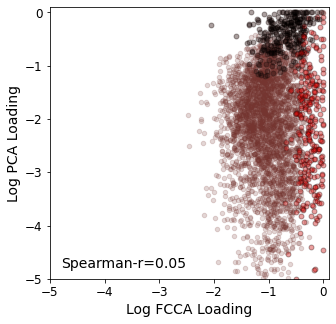

In [95]:
# Re-scatter with the top neurons highlighted
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

#df_ = apply_df_filters(loadings_df, dim=6)
df_ = loadings_df
ax.scatter(np.log10(df_['FCCA_loadings'].values), np.log10(df_['PCA_loadings'].values), alpha=0.2, color='#753530', s=20)

for i in range(len(top_neurons_l)):
    idxs1 = top_neurons_l[i]['top_neurons'][0, :]
    idxs2 = top_neurons_l[i]['top_neurons'][1, :]
    x = []
    y = []
    for j in range(len(idxs1)):
        d = apply_df_filters(df_, data_file=top_neurons_l[i]['data_file'], nidx=idxs1[j])
        assert(d.shape[0] == 1)
        x.append(d.iloc[0]['FCCA_loadings'])
        y.append(d.iloc[0]['PCA_loadings'])
    ax.scatter(np.log10(x), np.log10(y), color='r', alpha=0.25, edgecolors='k', s=25)

    x = []
    y = []
    for j in range(len(idxs1)):
        d = apply_df_filters(df_, data_file=top_neurons_l[i]['data_file'], nidx=idxs2[j])
        assert(d.shape[0] == 1)
        x.append(d.iloc[0]['FCCA_loadings'])
        y.append(d.iloc[0]['PCA_loadings'])
    ax.scatter(np.log10(x), np.log10(y), color='k', alpha=0.25, edgecolors='k', s=25)

ax.set_xlim([-5, 0.1])
ax.set_ylim([-5, 0.1])
ax.set_xlabel('Log FCCA Loading', fontsize=14)
ax.set_ylabel('Log PCA Loading', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Annotate with the spearman-r
r = scipy.stats.spearmanr(df_['FCCA_loadings'].values, df_['PCA_loadings'].values)[0]
ax.annotate('Spearman-r=%.2f' % r, (-4.8, -4.8), fontsize=14)



fig.savefig('/home/akumar/nse/neural_control/figs/final/FCAPCAscatter.pdf', bbox_inches='tight', pad_inches=0)

In [70]:
# Next, plot 10 examples of each neuron type smoothed and trial averaged

In [12]:
from scipy.ndimage import gaussian_filter1d

In [97]:
top_neurons_df = pd.DataFrame(top_neurons_l)

Processing spikes


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00,  7.28it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35.20it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 16.01it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 39.80it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 44.64it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 37.67it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 41.79it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 41.78it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 36.03it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35.24it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 26.68it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 31.42it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 32.73it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35.81it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 36.71it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 34.55it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35.94it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 31.19it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 26.38it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35.67it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35.19it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 35.83it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 30.70it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 29.94it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 24.85it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Processing spikes


100%|██████████| 1/1 [00:00<00:00, 22.67it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


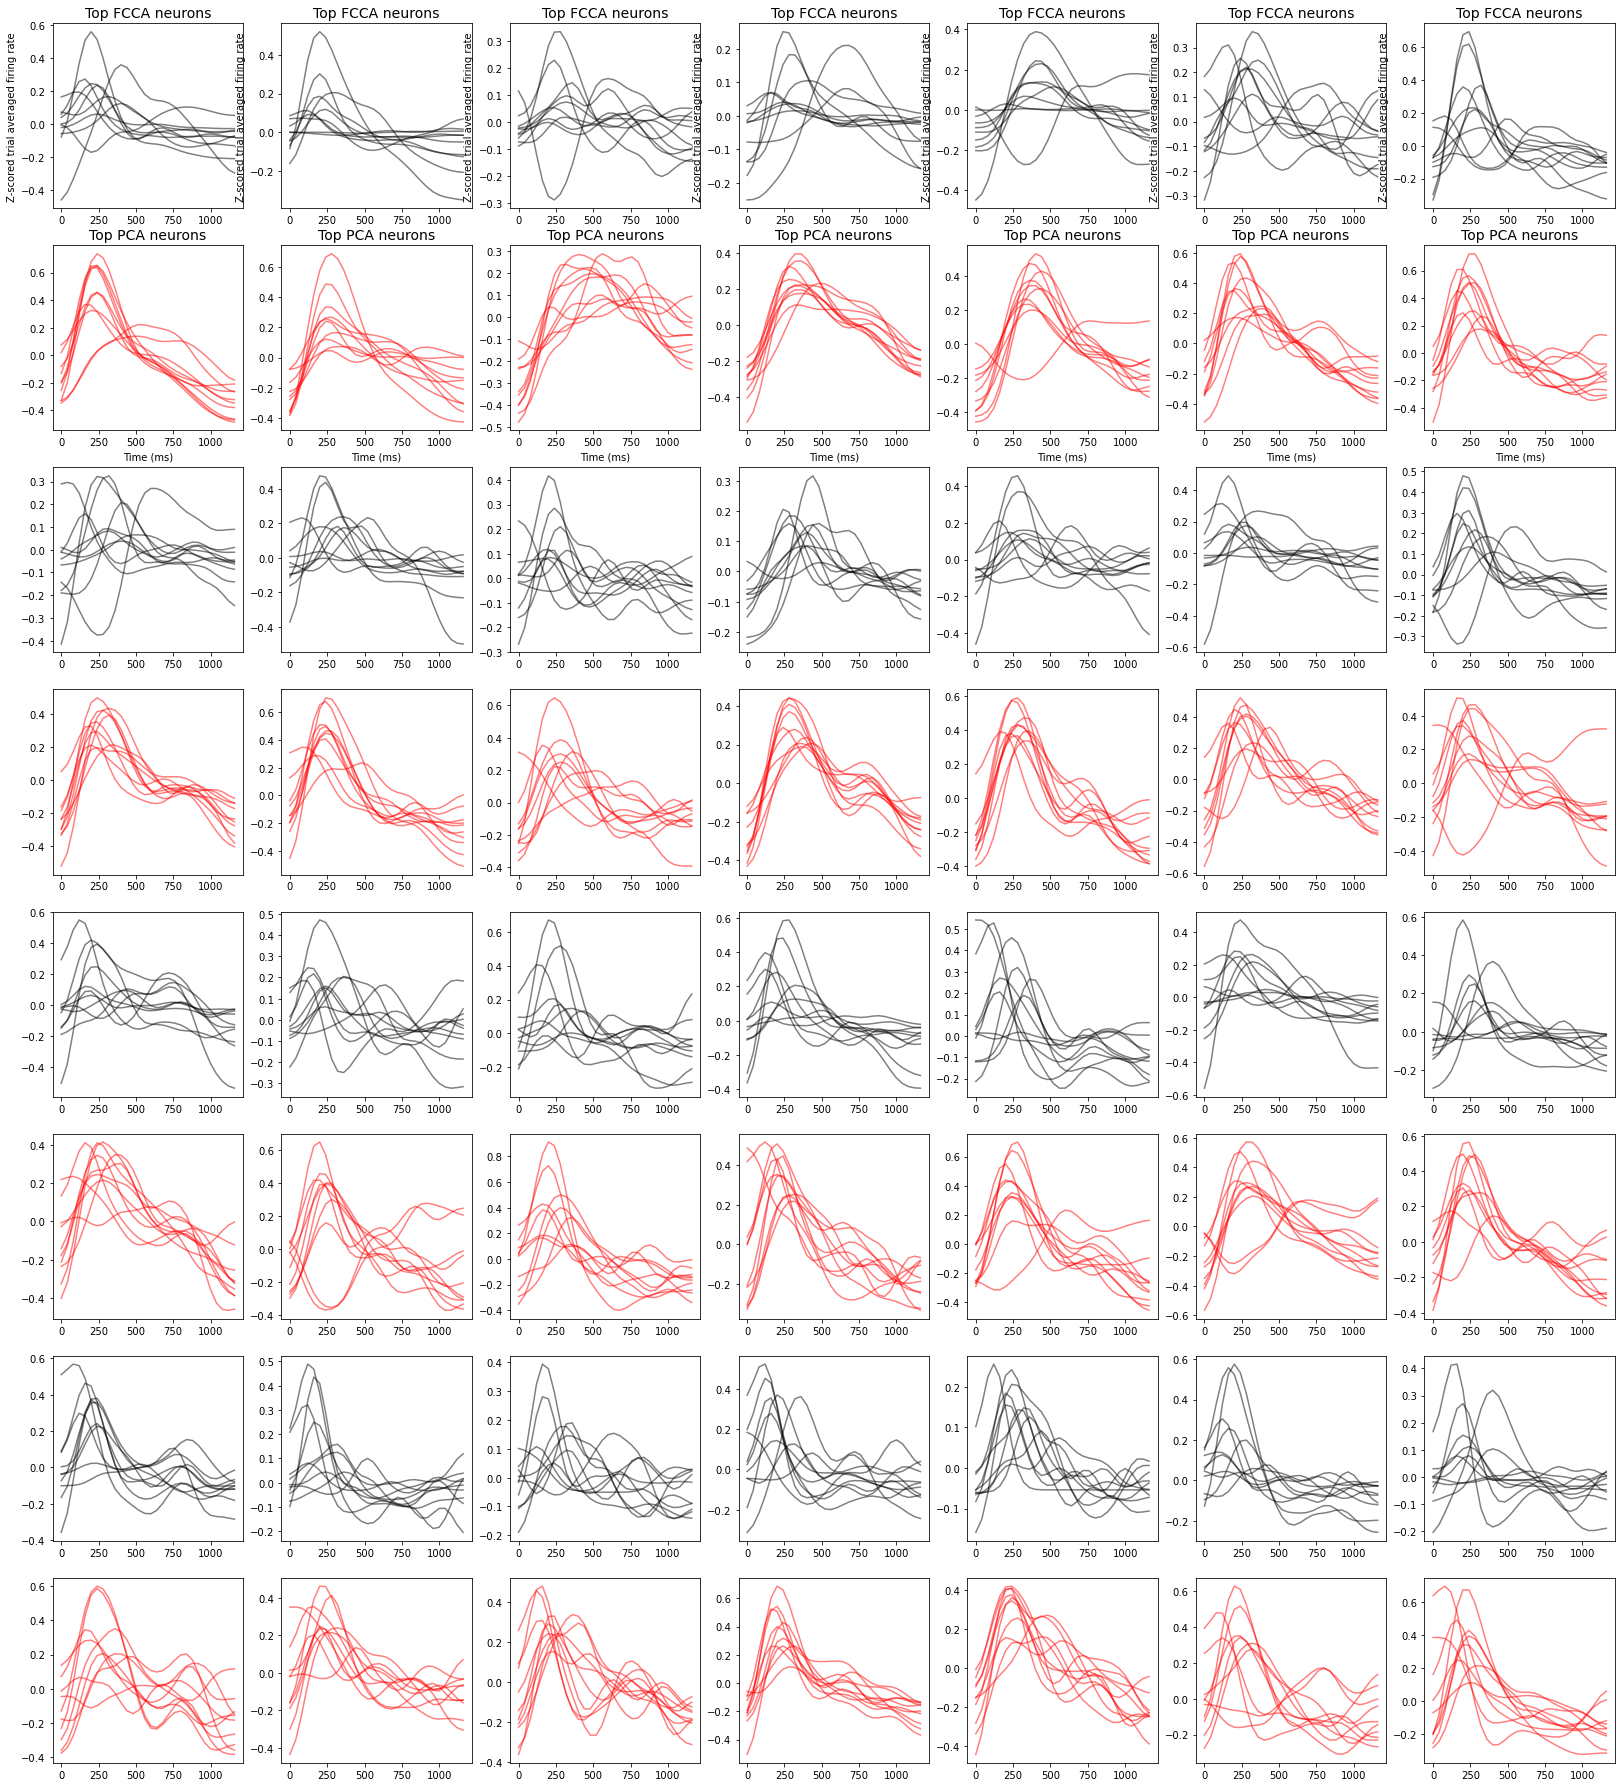

In [98]:
ndf = 7
fig, ax = plt.subplots(2 * 4, ndf, figsize=(4*ndf, 32))

for h, data_file in enumerate(data_files):

    df_ = apply_df_filters(top_neurons_df, data_file=data_file)
    dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=False)
    dat_segment = reach_segment_sabes(dat, start_time=start_times[data_file.split('.mat')[0]])
    
    T = 30
    t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
    valid_transitions = np.arange(t.size)[t >= T]

    # (Bin size 50 ms)
    time = 40 * np.arange(T)

    for i in range(2):
        for j in range(n):
            tn = df_.iloc[0]['top_neurons'][i, j]    
            try:
                x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, tn] 
                            for idx in valid_transitions])
            except:
                pdb.set_trace()
            
            # Mean subtract
#            x_ -= np.mean(x_, axis=1, keepdims=True)
            try:
                x_ = StandardScaler().fit_transform(x_.T).T
                x_ = gaussian_filter1d(x_, sigma=2)
                x_ = np.mean(x_, axis=0)

                if i == 0:
                    ax[2 * (h//7) + i, h % 7].plot(time, x_, 'k', alpha=0.5)
                if i == 1:
                    ax[2 * (h//7) + i, h % 7].plot(time, x_, 'r', alpha=0.5)
            except:
                continue

for i in range(ndf):
    ax[0, i].set_title('Top FCCA neurons', fontsize=14)
    ax[1, i].set_title('Top PCA neurons', fontsize=14)
    ax[1, i].set_xlabel('Time (ms)')
    ax[0, i].set_ylabel('Z-scored trial averaged firing rate')

# fig.savefig('psth_indy.pdf', bbox_inches='tight', pad_inches=0)

In [108]:
from mpl_toolkits.axisartist.axislines import AxesZero

Processing spikes


100%|██████████| 1/1 [00:00<00:00, 33.24it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


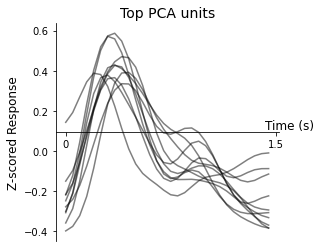

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

data_file = data_files[11]

df_ = apply_df_filters(top_neurons_df, data_file=data_file)
dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=False)
dat_segment = reach_segment_sabes(dat, start_time=start_times[data_file.split('.mat')[0]])

T = 30
t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
valid_transitions = np.arange(t.size)[t >= T]

# (Bin size 50 ms)
time = 50 * np.arange(T)

for j in range(10):
    tn = df_.iloc[0]['top_neurons'][1, j]    
    x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, tn] 
                for idx in valid_transitions])

    x_ = StandardScaler().fit_transform(x_.T).T
    x_ = gaussian_filter1d(x_, sigma=2)
    x_ = np.mean(x_, axis=0)

    ax.plot(time, x_, 'k', alpha=0.5)

#ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xticks([0, 1500])
ax.set_xticklabels([0, 1.5])

ax.set_xlabel('Time (s)', fontsize=12)
ax.xaxis.set_label_coords(1.05, 0.56)
ax.set_ylabel('Z-scored Response', fontsize=12)
ax.set_title('Top PCA units', fontsize=14)

fig.savefig('/home/akumar/nse/neural_control/figs/final/topPCApsth.pdf', bbox_inches='tight', pad_inches=0)

# ax[0, i].set_title('Top FCCA neurons', fontsize=14)
# ax[1, i].set_title('Top PCA neurons', fontsize=14)
# ax[1, i].set_xlabel('Time (ms)')
# ax[0, i].set_ylabel('Z-scored trial averaged firing rate')

# fig.savefig('psth_indy.pdf', bbox_inches='tight', pad_inches=0)

Processing spikes


100%|██████████| 1/1 [00:00<00:00, 42.26it/s]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


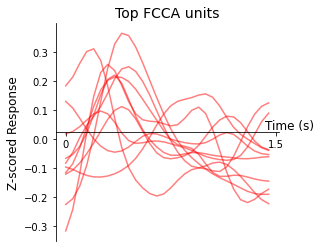

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

data_file = data_files[5]

df_ = apply_df_filters(top_neurons_df, data_file=data_file)
dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=False)
dat_segment = reach_segment_sabes(dat, start_time=start_times[data_file.split('.mat')[0]])

T = 30
t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
valid_transitions = np.arange(t.size)[t >= T]

# (Bin size 50 ms)
time = 50 * np.arange(T)

for j in range(10):
    tn = df_.iloc[0]['top_neurons'][0, j]    
    x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, tn] 
                for idx in valid_transitions])

    x_ = StandardScaler().fit_transform(x_.T).T
    x_ = gaussian_filter1d(x_, sigma=2)
    x_ = np.mean(x_, axis=0)

    ax.plot(time, x_, 'r', alpha=0.5)

#ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xticks([0, 1500])
ax.set_xticklabels([0, 1.5])

ax.set_xlabel('Time (s)', fontsize=12)
ax.xaxis.set_label_coords(1.05, 0.56)
ax.set_ylabel('Z-scored Response', fontsize=12)
ax.set_title('Top FCCA units', fontsize=14)

fig.savefig('/home/akumar/nse/neural_control/figs/final/topFCCApsth.pdf', bbox_inches='tight', pad_inches=0)

# ax[0, i].set_title('Top FCCA neurons', fontsize=14)
# ax[1, i].set_title('Top PCA neurons', fontsize=14)
# ax[1, i].set_xlabel('Time (ms)')
# ax[0, i].set_ylabel('Z-scored trial averaged firing rate')

# fig.savefig('psth_indy.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Next: Truncated histogram

In [14]:
def get_scalar(df_, stat, neu_idx):

    if stat == 'decoding_weights':
        decoding_win = df_.iloc[0]['decoder_params']['decoding_window']
        c = calc_loadings(df_.iloc[0]['decoding_weights'].T, d=decoding_win)[neu_idx]
    elif stat == 'encoding_weights':
        decoding_win = df_.iloc[0]['decoder_params']['decoding_window']
        c =  calc_loadings(df_.iloc[0]['encoding_weights'], d=decoding_win)[neu_idx]        
    elif stat in ['su_r2_pos', 'su_r2_vel', 'su_r2_enc', 'su_var', 'su_mmse', 'su_pi', 'su_fcca']:
        c = df_.iloc[0][stat][neu_idx]
    elif stat == 'orientation_tuning':
        c = np.zeros(8)
        for j in range(8):
            c[j] = df_.loc[df_['bin_idx'] == j].iloc[0]['tuning_r2'][j, 2, neu_idx]
        c = np.mean(c)
        # c = odf_.iloc[0]

    return c

In [15]:
with open('/home/akumar/nse/neural_control/data/sabes_su_df.dat', 'rb') as f:
    sabes_su_l = pickle.load(f)

sabes_su_df = pd.DataFrame(sabes_su_l)

In [16]:
# Dimensionality selection
itrim_df = loadings_df

In [19]:
data_files = np.unique(itrim_df['data_file'].values)

In [21]:
# Collect the desired single unit statistics into an array with the same ordering as those present in the loadings df
stats = ['decoding_weights', 'su_r2_enc', 'su_var', 'su_pi']

carray = []
for i, data_file in enumerate(data_files):
    df = apply_df_filters(itrim_df, data_file=data_file)
    carray_ = np.zeros((df.shape[0], len(stats)))
    for j in range(df.shape[0]):
        for k, stat in enumerate(stats):
            # Grab the unique identifiers needed
            nidx = df.iloc[j]['nidx']
            if stat == 'orientation_tuning':
                df_ = apply_df_filters(odf, file=data_file, tau=4)
            else:
                df_ = apply_df_filters(sabes_su_df, data_file=data_file)
            carray_[j, k] = get_scalar(df_, stat, nidx)
    carray.append(carray_)

In [25]:
su_r = np.zeros((len(carray), 4, carray[0].shape[1]))
keys = ['DCA_loadings', 'KCA_loadings', 'FCCA_loadings', 'PCA_loadings']
for i in range(len(carray)):
    for j in range(4):
        for k in range(carray[0].shape[1]):
            df = apply_df_filters(itrim_df, data_file=data_files[i])
            su_r[i, j, k] = scipy.stats.spearmanr(df[keys[j]].values, carray[i][:, k])[0]

In [154]:
su_r.shape

(4, 4)

In [32]:
np.sign(bars[2].get_height()

-0.19375074598414027

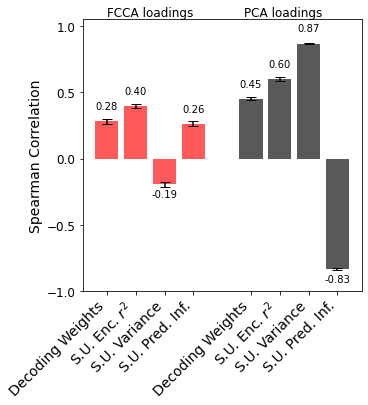

In [37]:
fig, ax = plt.subplots(figsize=(5, 5),)

bars = ax.bar([0, 1, 2, 3, 5, 6, 7, 8],
               np.mean(su_r[:, -2:, :], axis=0).ravel(),
               color=['r', 'r', 'r', 'r', 'k', 'k', 'k', 'k'], alpha=0.65,
               yerr=np.std(su_r[:, -2:, :], axis=0).ravel()/np.sqrt(28), capsize=5)


# Place numerical values above the bars
for rect in bars: 
    if rect.get_height() > 0:
        ax.text(rect.get_x() + rect.get_width()/2, np.sign(rect.get_height()) * (np.abs(rect.get_height()) + 0.075), '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=10)
    else:
        ax.text(rect.get_x() + rect.get_width()/2, np.sign(rect.get_height()) * (np.abs(rect.get_height()) + 0.11), '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=10)

ax.set_ylim([-1, 1.05])
ax.set_xticks([0, 1, 2, 3, 5, 6, 7, 8])

ax.set_xticklabels(['Decoding Weights', 'S.U. Enc. ' + r'$r^2$', 'S.U. Variance', 'S.U. Pred. Inf.',
                    'Decoding Weights', 'S.U. Enc. ' + r'$r^2$', 'S.U. Variance', 'S.U. Pred. Inf.'], rotation=45, fontsize=14, ha='right')

ax.tick_params(axis='y', labelsize=12)

ax.text(0, 1.05, 'FCCA loadings', fontsize=12, ha='left', va='bottom')
# ax.annotate("", xy=(-0.5, -0.3), xytext=(3.5, -0.3), 
#             xycoords='data', textcoords='data',
#             arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=-0.1'))

ax.text(4.75, 1.05, 'PCA loadings', fontsize=12, ha='left', va='bottom')
# ax.annotate("", xy=(4.5, -0.3), xytext=(8.5, -0.3), 
#             xycoords='data', textcoords='data',
#             arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=-0.1'))

ax.set_ylabel('Spearman Correlation', fontsize=14)
ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
fig.savefig('/home/akumar/nse/neural_control/figs/final/su_spearman_d%d.pdf' % DIM, bbox_inches='tight', pad_inches=0)

### jPCA stuff

In [16]:
from dca.methods_comparison import JPCA
from pyuoi.linear_model.var  import VAR
from neurosim.models.var import form_companion
from scipy.ndimage import gaussian_filter1d
from segmentation import reach_segment_sabes, measure_straight_dev

In [17]:
data_files = np.unique(sabes_df['data_file'].values)

In [18]:
# Now do subspace identification/VAR inference within these 
# results = []
resultsd3 = []
for i, data_file in tqdm(enumerate(data_files)):
    dat = load_sabes('%s/%s' % (dpath, data_file))
    y = np.squeeze(dat['spike_rates'])
    for dimreduc_method in ['DCA', 'KCA', 'LQGCA', 'PCA']:
        df_ = apply_df_filters(sabes_df, data_file=data_file, fold_idx=0, dim=6, dimreduc_method=dimreduc_method)
        if dimreduc_method == 'LQGCA':
            df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 5})
        V = df_.iloc[0]['coef']
        if dimreduc_method == 'PCA':
            V = V[:, 0:6]        
        # Project data
        yproj = y @ V

        result_ = {}
        result_['data_file'] = data_file
        result_['dimreduc_method'] = dimreduc_method

        # # Fit subspace identification
        # ssid = SubspaceIdentification()
        # A, C, Cbar, L0, Q, R, S = ssid.identify(yproj, order=6)

        # result_['ssid_A'] = A

        # Fit VAR(1) and VAR(2)
        varmodel = VAR(estimator='ols', order=1)
        varmodel.fit(yproj)
        result_['var1_A'] = form_companion(varmodel.coef_) 

        varmodel = VAR(estimator='ols', order=2)
        varmodel.fit(yproj)
        result_['var2_A'] = form_companion(varmodel.coef_)

        resultsd3.append(result_)


0it [00:00, ?it/s]

Processing spikes


  0%|          | 0/1 [00:02<?, ?it/s]
0it [00:02, ?it/s]


KeyboardInterrupt: 

In [19]:
# with open('Atmp.dat', 'wb') as f:
#     f.write(pickle.dumps(resultsd3))
with open('Atmp.dat', 'rb') as f:
    resultsd3 = pickle.load(f)

In [20]:
A_df = pd.DataFrame(resultsd3)

In [36]:
# Measure (1) largest amplification, (2) Angle between largest amplification vector and largest rotation vector, (3) 
d_U = np.zeros((28, 4, 3))
for i in range(28):
    for j, dimreduc_method in enumerate(['DCA', 'KCA', 'LQGCA', 'PCA']):
        df_ = apply_df_filters(A_df, data_file=data_files[i], dimreduc_method=dimreduc_method)
        # A = df_.iloc[0]['ssid_A']
        # U, P = scipy.linalg.polar(A)
        # d_U[i, j, 0] = np.linalg.norm(A - U)/np.linalg.norm(A)
        A = df_.iloc[0]['var1_A']
        U, P = scipy.linalg.polar(A)
        d_U[i, j, 1] = np.linalg.norm(A - U)/np.linalg.norm(A)
        #d_U[i, j, 1] = 1 - np.linalg.norm(U)/np.linalg.norm(A)
        A = df_.iloc[0]['var2_A']
        U, P = scipy.linalg.polar(A)
        d_U[i, j, 2] = np.linalg.norm(A - U)/np.linalg.norm(A)


In [22]:
np.argmax(d_U[:, -1, 1])

20

In [23]:
# Next up:
# Rotational trajectories.
data_file = data_files[8]

df1 = apply_df_filters(sabes_df, data_file=data_file, fold_idx=0, dim=6, dimreduc_method='PCA')
df2 = apply_df_filters(sabes_df, data_file=data_file, fold_idx=0, dim=6, dimreduc_method='LQGCA', dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':5})


datpath = '/mnt/Secondary/data/sabes'
dat = load_sabes('%s/%s' % (datpath, data_file))
dat = reach_segment_sabes(dat, start_times[data_file.split('.mat')[0]])

x = np.array([StandardScaler().fit_transform(dat['spike_rates'][j, ...]) 
              for j in range(dat['spike_rates'].shape[0])])
xpca = x @ df1.iloc[0]['coef'][:, 0:6]
xdca = x @ df2.iloc[0]['coef']

#     var1 = VAR(estimator='ols')
#     var1.fit(xpca)

#     var2 = VAR(estimator='ols')
#     var2.fit(xdca)

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.48s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [24]:
jpca1 = JPCA(n_components=6, mean_subtract=False)
jpca1.fit(xpca)

jpca2 = JPCA(n_components=6, mean_subtract=False)
jpca2.fit(xdca)

xpca_j = jpca1.transform(xpca)
xdca_j = jpca2.transform(xdca)

In [19]:
# Measure the straight_dev of the projected neural data
pca_straightdev = np.zeros(len(dat['target_pairs']))
dca_straightdev = np.zeros(len(dat['target_pairs']))
transition_times = dat['transition_times']
for i in range(len(dat['target_pairs'])):
    
    trajectory = gaussian_filter1d(xpca_j[0, transition_times[i][0]:transition_times[i][1]], 
                                   sigma=5, axis=0)
    start = trajectory[0, :]
    end = trajectory[-1, :]
    
    pca_straightdev[i] = measure_straight_dev(trajectory, start, end)

    trajectory = gaussian_filter1d(xdca_j[0, transition_times[i][0]:transition_times[i][1]], 
                                   sigma=5, axis=0)
    start = trajectory[0, :]
    end = trajectory[-1, :]
    dca_straightdev[i] = measure_straight_dev(trajectory, start, end)
    
    
pca_devorder = np.argsort(pca_straightdev)[::-1]
dca_devorder = np.argsort(dca_straightdev)[::-1]


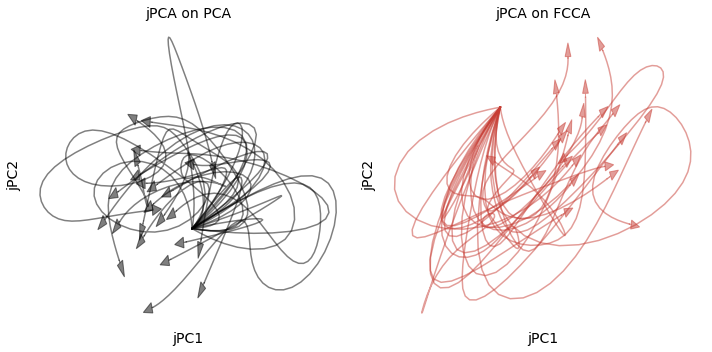

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(25):
    
    idx = pca_devorder[i]
    trajectory = gaussian_filter1d(xpca_j[0, transition_times[idx][0]:transition_times[idx][1]], 
                                   sigma=5, axis=0)

    # Center trajectories
    trajectory -= trajectory[0]
    ax[0].plot(trajectory[:, 0], trajectory[:, 1], 'k', alpha=0.5)
    ax[0].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                   head_width=0.15, color="k", alpha=0.5)
    
    
    idx = dca_devorder[i]
    trajectory = gaussian_filter1d(xdca_j[0, transition_times[idx][0]:transition_times[idx][1]], 
                                   sigma=5, axis=0)

    # Center trajectories
    trajectory -= trajectory[0]
    ax[1].plot(trajectory[:, 0], trajectory[:, 1], '#c73d34', alpha=0.5)
    ax[1].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                   head_width=0.1, color="#c73d34", alpha=0.5)

    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
    
ax[0].set_title('jPCA on PCA', fontsize=14)
ax[0].set_ylabel('jPC2', fontsize=14)
ax[0].set_xlabel('jPC1', fontsize=14)

ax[1].set_title('jPCA on FCCA', fontsize=14)
ax[1].set_ylabel('jPC2', fontsize=14)
ax[1].set_xlabel('jPC1', fontsize=14)

ax[0].spines['right'].set_color('none')
ax[0].spines['top'].set_color('none')
ax[0].spines['left'].set_color('none')
ax[0].spines['bottom'].set_color('none')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].spines['right'].set_color('none')
ax[1].spines['top'].set_color('none')
ax[1].spines['left'].set_color('none')
ax[1].spines['bottom'].set_color('none')
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.tight_layout()

fig.savefig('/home/akumar/nse/neural_control/figs/final/trajectories.pdf', bbox_inches='tight', pad_inches=0)

In [52]:
# Histogram of deviation from polar decomposition


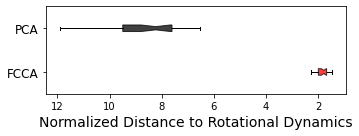

In [40]:
# Boxplots
fig, ax = plt.subplots(1, 1, figsize=(5, 2))

medianprops = dict(linewidth=0)
bplot = ax.boxplot([d_U[:, 2, 1], d_U[:, 3, 1]], patch_artist=True, medianprops=medianprops, notch=True, vert=False, showfliers=False)

method1 = 'FCCA'
method2 = 'PCA'
ax.set_yticklabels([method1, method2], fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Normalized Distance to Rotational Dynamics', fontsize=14)
ax.invert_xaxis()
# fill with colors
colors = ['red', 'black']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.75)

fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/final/Dist_to_U.pdf', bbox_inches='tight', pad_inches=0)